In [339]:
import numpy as np
import pandas as pd
import random
import math
import matplotlib as mlt
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import seaborn as sns
from IPython.display import Image

import quandl as quandl
import yfinance as yf
quandl.ApiConfig.api_key = 'BzVGriov2pgK4PAYr4sy'

%config InlineBackend.figure_format = 'svg'
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

##### Helper Functions

In [284]:
def cal_perc_missing(df, title = '', rotate_angle = 0, figsize = (10,3)):
    miss_per = pd.DataFrame(df.isnull().sum(axis =0)*100/df.shape[0], columns=['Missing %']).round(2).sort_values(by=['Missing %'], ascending=False)
    display(miss_per.T)
    plt.figure(figsize = figsize)
    plt.xticks(rotation = rotate_angle)
    plt.title(title)
    plt.ylabel('Missing %')
    plt.xlabel('Features')
    _ = plt.bar(x = miss_per.index, height=miss_per['Missing %'], width=0.3)

def z_scaling(df):
    return((df - df.mean())/df.std())

def heatmap(df, annot = True, shape = (10,8)):
    plt.figure(figsize = shape)
    mask = np.triu(df.corr())
    ax = sns.heatmap(df.corr(), annot = annot, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', fmt='.1g', mask = mask)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

#### BTC Tech Indicator Data Exploration

In [253]:
quandl.bulkdownload('BCHAIN')
btc_tech_df = pd.read_csv('BCHAIN/BCHAIN_20200913.csv', header= None, names=['name', 'date', 'value'], parse_dates=['date'])
btc_tech_df = btc_tech_df.pivot(index='date', columns='name', values='value')
btc_tech_df.tail()

name        ATRCT     AVBLS  BCDDC  BCDDE  BCDDM  BCDDW  BCDDY          BLCHS  \
date                                                                            
2020-09-10    NaN  1.194565    NaN    NaN    NaN    NaN    NaN  298351.696030   
2020-09-11    NaN  1.333326    NaN    NaN    NaN    NaN    NaN  298529.737255   
2020-09-12    NaN  1.328602    NaN    NaN    NaN    NaN    NaN  298740.422485   
2020-09-13    NaN  1.060539    NaN    NaN    NaN    NaN    NaN  298923.716597   
2020-09-14    NaN       NaN    NaN    NaN    NaN    NaN    NaN            NaN   

name            CPTRA     CPTRV  ...     NTRAN        NTRAT        NTRBL  \
date                             ...                                       
2020-09-10  32.983336  0.702068  ...  314864.0  566471474.0  2113.181208   
2020-09-11  32.782606  0.751036  ...  345981.0  566786901.0  2189.753165   
2020-09-12  31.841403  0.618233  ...  308323.0  567132303.0  2234.224638   
2020-09-13  38.678974  1.373667  ...  300152.0  567440733.0  1765.600000   
2020-09-14        NaN       NaN  ...       NaN          NaN          NaN   

name           NTREP        TOTBC         TOUTV       TRFEE         TRFUS  \
date                                                                        
2020-09-10  310690.0  18484581.25  3.188716e+06   89.195800  9.101633e+05   
2020-09-11  341825.0  18485456.25  3.493320e+06  110.389664  1.140821e+06   
2020-09-12  304149.0  18486337.50  3.130285e+06   95.167103  9.809460e+05   
2020-09-13  296767.0  18487437.50  2.593737e+06   58.115755  6.089183e+05   
2020-09-14       NaN          NaN           NaN         NaN           NaN   

name               TRVOU  TVTVR  
date                             
2020-09-10  1.941569e+08    NaN  
2020-09-11  1.133833e+08    NaN  
2020-09-12  1.470556e+08    NaN  
2020-09-13  1.016532e+08    NaN  
2020-09-14  5.785761e+07    NaN  

[5 rows x 33 columns]

In [249]:
btc_tech_df.describe().round(3)

name      ATRCT     AVBLS         BCDDC         BCDDE         BCDDM  \
count  3504.000  4272.000  2.756000e+03  2.756000e+03  2.756000e+03   
mean      6.769     0.465  3.831027e+09  4.268389e+06  3.761201e+06   
std       5.216     0.441  3.756570e+09  7.812780e+06  7.657626e+06   
min       0.000     0.000  0.000000e+00  0.000000e+00  0.000000e+00   
25%       0.000     0.020  2.133639e+08  5.299470e+05  3.242160e+05   
50%       7.667     0.295  2.432947e+09  2.530878e+06  1.966104e+06   
75%       9.881     0.909  7.216988e+09  5.004635e+06  4.190439e+06   
max      47.733     1.422  1.177605e+10  1.732980e+08  1.727464e+08   

name          BCDDW         BCDDY       BLCHS     CPTRA         CPTRV  ...  \
count  2.756000e+03  2.756000e+03    4272.000  4272.000  4.272000e+03  ...   
mean   4.064165e+06  1.874889e+06   73427.366    21.227  1.479691e+04  ...   
std    7.753399e+06  6.447294e+06   90463.723    25.645  6.418160e+05  ...   
min    0.000000e+00  0.000000e+00       0.000     0.000  0.000000e+00  ...   
25%    4.688145e+05  0.000000e+00     547.250     3.634  1.034000e+00  ...   
50%    2.287534e+06  4.491245e+05   23993.000     9.049  1.817000e+00  ...   
75%    4.696996e+06  1.683390e+06  136140.204    33.386  4.482000e+00  ...   
max    1.730718e+08  1.702367e+08  298923.717   161.686  3.650000e+07  ...   

name        NTRAN         NTRAT     NTRBL       NTREP         TOTBC  \
count    4272.000  4.272000e+03  4272.000    4272.000  4.271000e+03   
mean   132937.075  1.407466e+08   890.802  125317.166  1.185453e+07   
std    124944.800  1.709468e+08   848.739  123204.808  5.596292e+06   
min         0.000  1.000000e+00     1.000       0.000  5.000000e+01   
25%      6986.000  1.988054e+06    48.000    5884.500  7.821325e+06   
50%     81567.000  5.094556e+07   540.000   75476.500  1.347862e+07   
75%    246268.250  2.611732e+08  1680.967  239588.250  1.661688e+07   
max    490644.000  5.674407e+08  2762.541  470650.000  1.848744e+07   

name          TOUTV     TRFEE         TRFUS         TRVOU     TVTVR  
count  4.272000e+03  4272.000  4.272000e+03  4.273000e+03  2753.000  
mean   1.339027e+06    51.833  2.729317e+05  1.134578e+08    12.195  
std    1.995179e+06   100.547  1.157109e+06  2.958240e+08    19.227  
min    0.000000e+00     0.000  0.000000e+00  0.000000e+00     0.000  
25%    4.479261e+05     7.151  4.401600e+01  2.309887e+05     1.166  
50%    9.846578e+05    21.743  6.247208e+03  6.157878e+06     5.427  
75%    1.715991e+06    46.547  1.411571e+05  9.717566e+07    14.338  
max    4.599222e+07  1495.946  2.272484e+07  5.352016e+09   224.065  

[8 rows x 33 columns]

name       MIOPM  TVTVR  NETDF  BCDDC  BCDDE  BCDDM  BCDDW  BCDDY  ATRCT  \
Missing %   36.3  35.57  35.57   35.5   35.5   35.5   35.5   35.5   18.0   

name       MWNTD  ...  BLCHS  DIFF  MKTCP  AVBLS  MIREV  CPTRA  ETRVU  ETRAV  \
Missing %   0.87  ...   0.02  0.02   0.02   0.02   0.02   0.02   0.02   0.02   

name       TRVOU  MKPRU  
Missing %    0.0    0.0  

[1 rows x 33 columns]

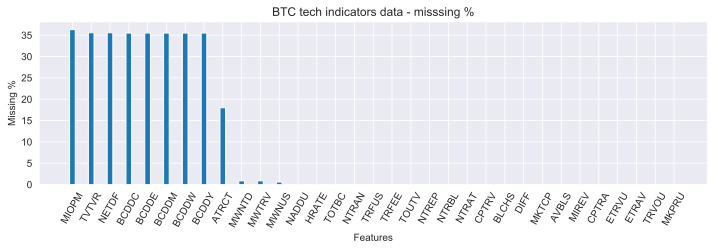

In [260]:
cal_perc_missing(btc_tech_df, rotate_angle=60, figsize=(12,3), title='BTC tech indicators data - misssing %')

In [346]:
## Normalizing the data after taking log of all values 
temp = np.log(df)
temp = temp.replace([np.inf, -np.inf], 0)
df_normalized = z_scaling(temp)
df_normalized.head()

name           ATRCT     AVBLS     BCDDC     BCDDE     BCDDM     BCDDW  \
date                                                                     
2009-01-03 -1.474559 -1.986513 -5.537607 -2.702035 -2.184484 -2.441472   
2009-01-04 -1.474559  0.817103 -5.537607 -2.702035 -2.184484 -2.441472   
2009-01-05 -1.474559  0.817103 -5.537607 -2.702035 -2.184484 -2.441472   
2009-01-06 -1.474559  0.817103 -5.537607 -2.702035 -2.184484 -2.441472   
2009-01-07 -1.474559  0.817103 -5.537607 -2.702035 -2.184484 -2.441472   

name          BCDDY     BLCHS     CPTRA     CPTRV  ...     NTRAN     NTRAT  \
date                                               ...                       
2009-01-03 -1.48335 -1.912153 -1.598156 -0.643029  ... -3.755484 -4.811874   
2009-01-04 -1.48335 -1.912153 -1.598156 -0.643029  ... -3.755484 -4.811874   
2009-01-05 -1.48335 -1.912153 -1.598156 -0.643029  ... -3.755484 -4.811874   
2009-01-06 -1.48335 -1.912153 -1.598156 -0.643029  ... -3.755484 -4.811874   
2009-01-07 -1.48335 -1.912153 -1.598156 -0.643029  ... -3.755484 -4.811874   

name           NTRBL     NTREP      TOTBC     TOUTV     TRFEE     TRFUS  \
date                                                                      
2009-01-03 -1.985545 -3.708772 -11.190956 -4.672718 -1.348808 -1.501352   
2009-01-04 -1.985545 -3.708772 -11.190956 -6.646487 -1.348808 -1.501352   
2009-01-05 -1.985545 -3.708772 -11.190956 -6.646487 -1.348808 -1.501352   
2009-01-06 -1.985545 -3.708772 -11.190956 -6.646487 -1.348808 -1.501352   
2009-01-07 -1.985545 -3.708772 -11.190956 -6.646487 -1.348808 -1.501352   

name           TRVOU     TVTVR  
date                            
2009-01-03 -2.172229 -1.241183  
2009-01-04 -2.172229 -1.241183  
2009-01-05 -2.172229 -1.241183  
2009-01-06 -2.172229 -1.241183  
2009-01-07 -2.172229 -1.241183  

[5 rows x 33 columns]

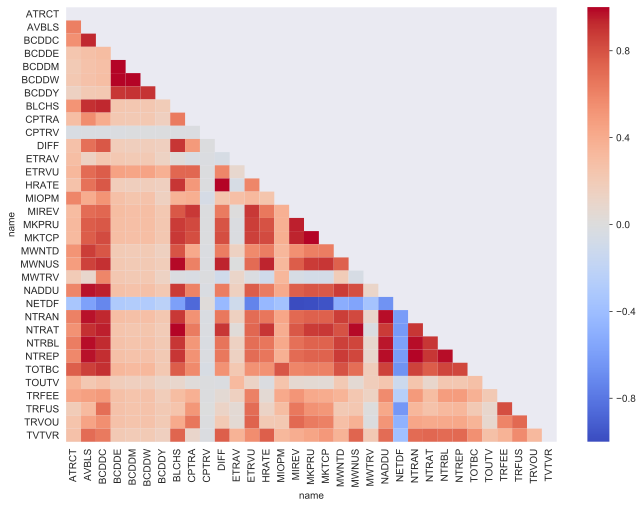

In [291]:
heatmap(btc_tech_df, shape = (11,8), annot=False)

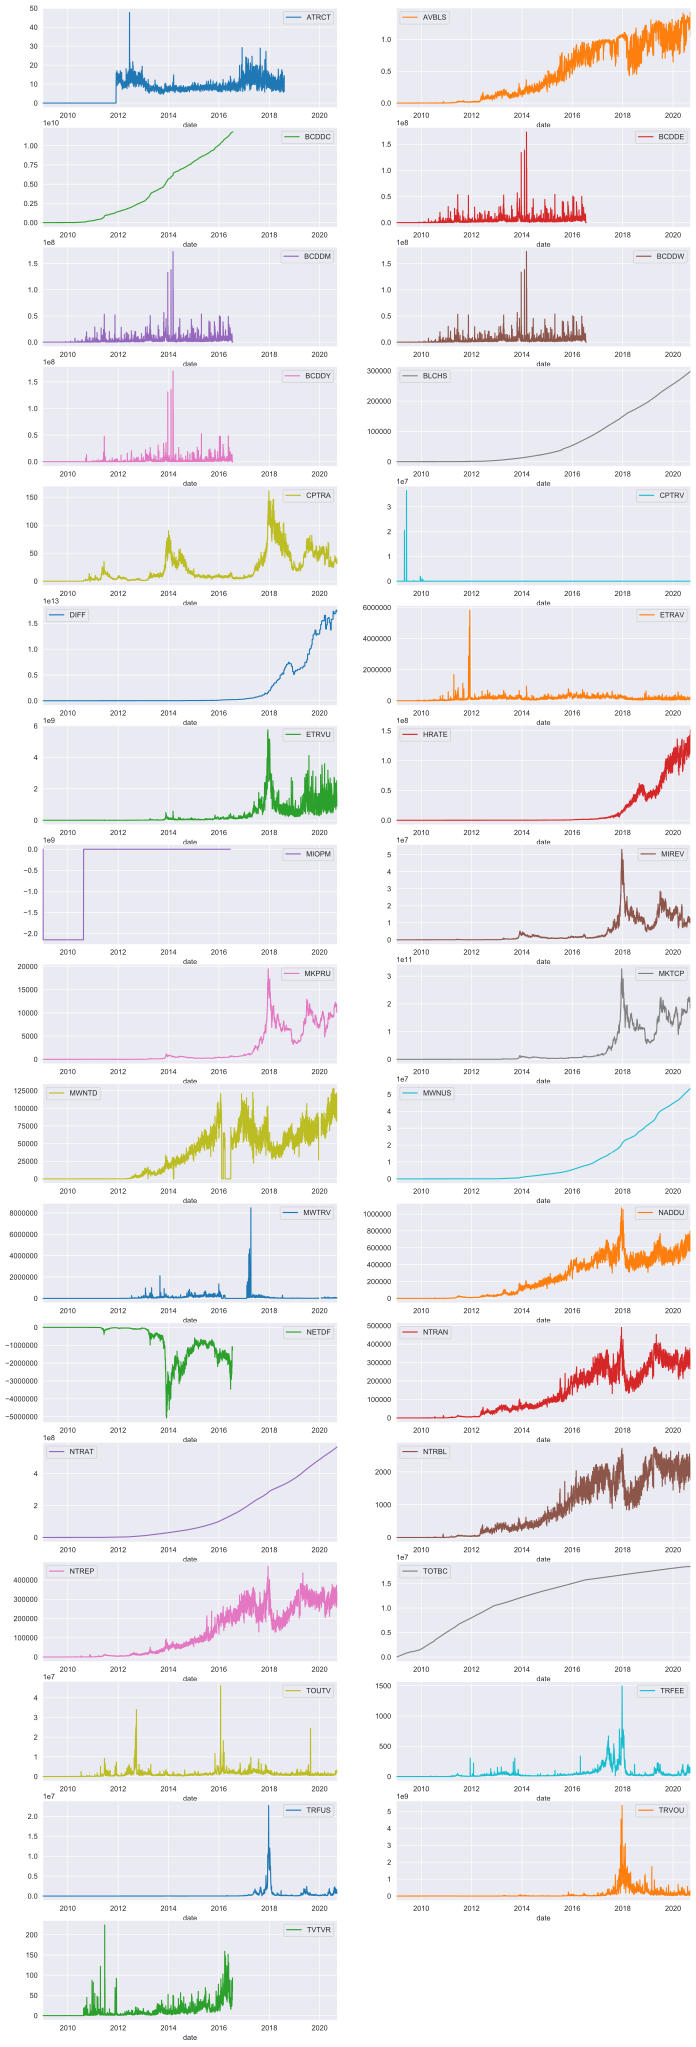

In [348]:
temp = btc_tech_df
x = math.ceil(temp.shape[1]/2)
temp.plot(figsize = (16,3*x), subplots = True, sharex = False, layout=(x,2));

#### Global Stock Data Exploration

In [246]:
## Equity index data
## sp500
## nikkie 255
## volatility sp500 index
## dax index
## uk 100 index
## shanghai composite index

start_date = "2010-05-31"

sp500 = yf.Ticker('^GSPC')
sp500 = sp500.history(start = start_date)

ni255 = yf.Ticker('^N225')
ni255 = ni255.history(start = start_date)

dax = yf.Ticker('^GDAXI')
dax = dax.history(start = start_date)

sha = yf.Ticker('000001.SS')
sha = sha.history(start = start_date)

ukx = yf.Ticker('^FTSE')
ukx = ukx.history(start = start_date)

vix = yf.Ticker('^Vix')
vix = vix.history(start = start_date)

stock_index = pd.concat([sp500['Close'], ni255['Close'], dax['Close'], sha['Close'], ukx['Close'], vix['Close']], axis = 1)
stock_index.columns = ['sp500', 'ni255', 'dax', 'sha', 'ukx', 'vix']
stock_index.head()

sp500    ni255      dax      sha     ukx    vix
Date                                                         
2010-05-31      NaN  9768.70  5964.33  2592.15     NaN    NaN
2010-06-01  1070.71  9711.83  5981.27  2568.28  5163.3  35.54
2010-06-02  1098.38  9603.24  5981.20  2571.42  5151.3  30.17
2010-06-03  1102.83  9914.19  6054.63  2552.66  5211.2  29.46
2010-06-04  1064.88  9901.19  5938.88  2553.59  5126.0  35.48

In [233]:
stock_index.describe()

sp500         ni255           dax          sha          ukx  \
count  2593.000000   2524.000000   2610.000000  2505.000000  2598.000000   
mean   2072.990397  16399.225376   9852.107816  2808.936691  6542.699065   
std     625.497510   4987.523319   2340.856760   527.097657   697.131494   
min    1022.580000   8160.010000   5072.330000  1950.010000  4805.800000   
25%    1460.910000  10608.642500   7528.460000  2356.500000  5945.475000   
50%    2056.150000  16974.125000  10008.855000  2862.560000  6605.300000   
75%    2635.670000  20686.292500  12002.465000  3135.000000  7164.325000   
max    3580.840000  24270.620000  13789.000000  5166.350000  7877.500000   

               vix  
count  2593.000000  
mean     17.614674  
std       7.390294  
min       9.140000  
25%      13.100000  
50%      15.520000  
75%      19.490000  
max      82.690000

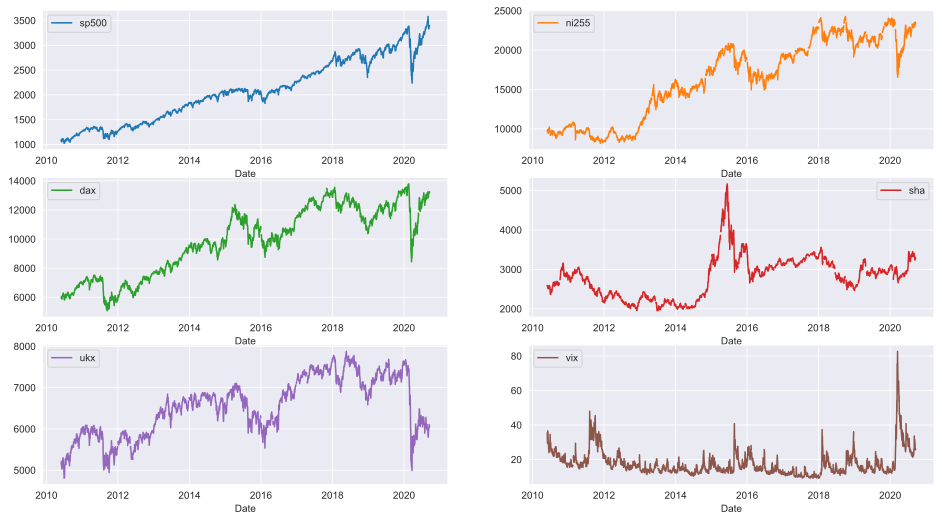

In [351]:
temp = stock_index
x = math.ceil(currency.shape[1]/2)
temp.plot(figsize = (16,3*x), subplots = True, sharex = False, layout=(x,2));

sha  ni255  sp500   vix   ukx   dax
Missing %  6.6   5.89   3.32  3.32  3.13  2.68

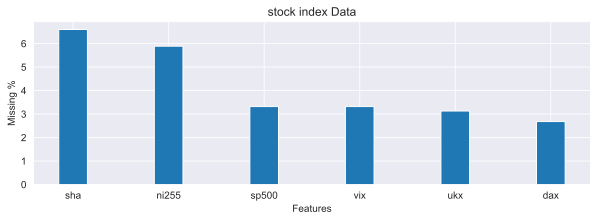

In [354]:
cal_perc_missing(stock_index, title='stock index Data')

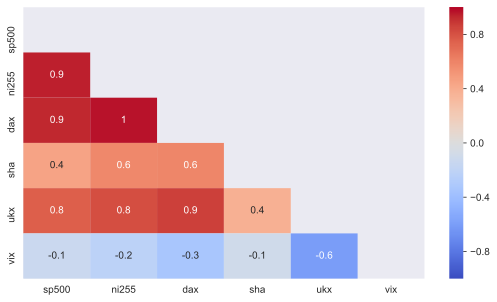

In [293]:
heatmap(stock_index, shape = (9,5), annot=True)

#### Currency Data Exploration

In [167]:
eurusd = yf.Ticker('EURUSD=X')
eurusd = eurusd.history(start = start_date)

usdjpy = yf.Ticker('USDJPY=X')
usdjpy = usdjpy.history(start = start_date)

audusd = yf.Ticker('AUDUSD=X')
audusd = audusd.history(start = start_date)

usdcad = yf.Ticker('USDCAD=X')
usdcad = usdcad.history(start = start_date)

gbpusd = yf.Ticker('GBPUSD=X')
gbpusd = gbpusd.history(start = start_date)

nzdusd = yf.Ticker('NZDUSD=X')
nzdusd = nzdusd.history(start = start_date)

gbpjpy = yf.Ticker('GBPJPY=X')
gbpjpy = gbpjpy.history(start = start_date)

eurjpy = yf.Ticker('EURJPY=X')
eurjpy = eurjpy.history(start = start_date)

audjpy = yf.Ticker('AUDJPY=X')
audjpy = audjpy.history(start = start_date)

usdchf = yf.Ticker('USDCHF=X')
usdchf = usdchf.history(start = start_date)

euraud = yf.Ticker('EURAUD=X')
euraud = euraud.history(start = start_date)

currency = pd.concat([eurusd['Close'], usdjpy['Close'], audusd['Close'], usdcad['Close'], gbpusd['Close'],
                      nzdusd['Close'], gbpjpy['Close'], eurjpy['Close'], audjpy['Close'], usdchf['Close'],
                      euraud['Close']], axis = 1)

currency.columns = ['eur_usd', 'usd_jpy', 'aud_usd', 'usd_cad', 'gbp_usd', 'nzd_usd', 'gbp_jpy', 'eur_jpy', 'aud_jpy',
                       'usd_chf', 'eur_aud']

currency.head()

eur_usd  usd_jpy  aud_usd  usd_cad  gbp_usd  nzd_usd  gbp_jpy  \
Date                                                                        
2010-05-31   1.2288   91.190   0.8466   1.0431   1.4522   0.6812  132.400   
2010-06-01   1.2233   91.100   0.8332   1.0538   1.4667   0.6772  133.582   
2010-06-02   1.2239   92.190   0.8418   1.0388   1.4650   0.6805  135.049   
2010-06-03   1.2169   92.623   0.8434   1.0403   1.4634   0.6838  135.513   
2010-06-04   1.1971   91.880   0.8242   1.0615   1.4458   0.6710  132.770   

            eur_jpy  aud_jpy  usd_chf  eur_aud  
Date                                            
2010-05-31  112.050  77.1715   1.1563   1.4511  
2010-06-01  111.430  75.8100   1.1555   1.4682  
2010-06-02  112.820  77.5795   1.1552   1.4535  
2010-06-03  112.691  78.0990   1.1561   1.4425  
2010-06-04  109.960  75.6990   1.1621   1.4523

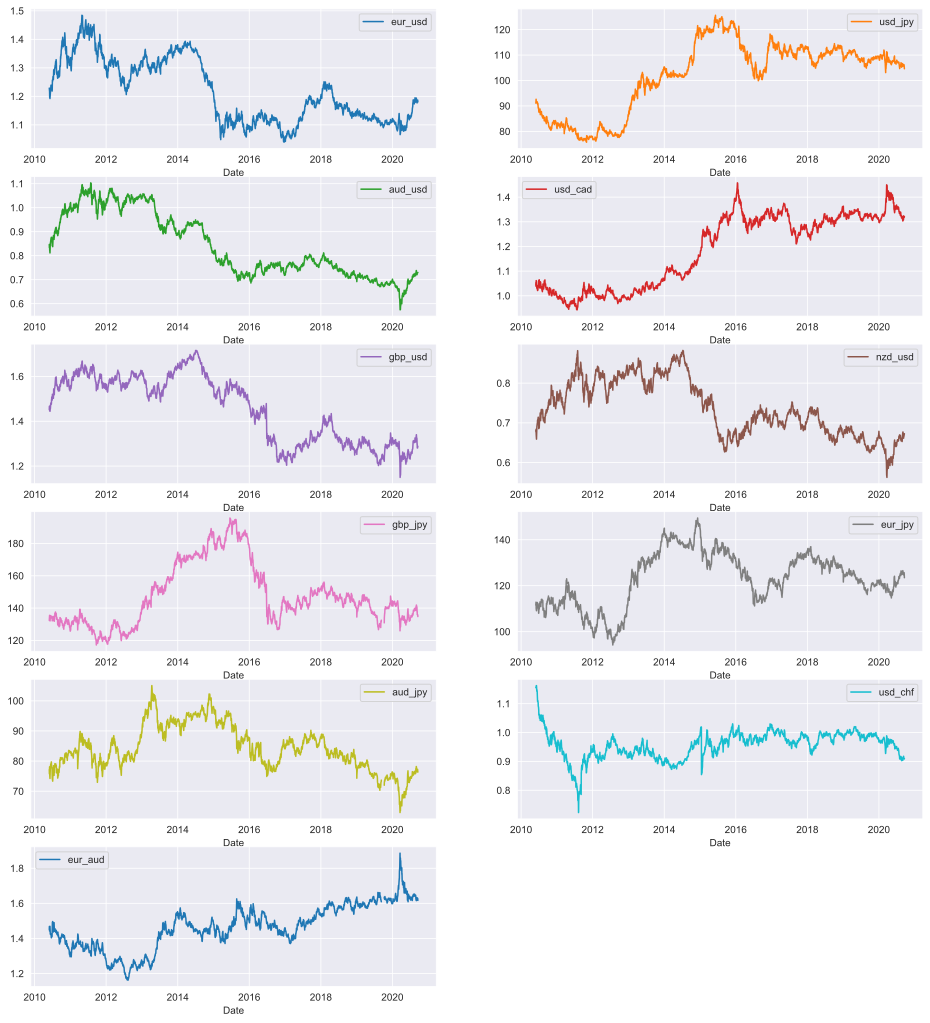

In [349]:
temp = currency
x = math.ceil(currency.shape[1]/2)
temp.plot(figsize = (16,3*x), subplots = True, sharex = False, layout=(x,2));

In [201]:
currency.describe()

eur_usd      usd_jpy      aud_usd      usd_cad      gbp_usd  \
count  2684.000000  2684.000000  2683.000000  2683.000000  2684.000000   
mean      1.218728   102.047165     0.842062     1.186106     1.456866   
std       0.111815    13.792730     0.133389     0.146811     0.148493   
min       1.039000    75.740000     0.574300     0.943200     1.149400   
25%       1.119800    89.580750     0.727600     1.027800     1.304500   
50%       1.185650   106.824000     0.782800     1.250300     1.511650   
75%       1.319100   111.533750     0.971950     1.318550     1.585550   
max       1.484400   125.629000     1.103500     1.457800     1.716100   

           nzd_usd      gbp_jpy      eur_jpy      aud_jpy      usd_chf  \
count  2684.000000  2665.000000  2666.000000  2667.000000  2681.000000   
mean      0.737527   147.694794   123.229675    84.451366     0.956311   
std       0.070428    19.041562    11.630712     7.424576     0.047470   
min       0.562600   117.180000    94.210000    62.918000     0.722800   
25%       0.677200   132.775000   114.787000    79.193000     0.927200   
50%       0.728300   143.305000   124.147500    83.406000     0.964400   
75%       0.802000   157.620000   132.076000    89.607500     0.989100   
max       0.882400   195.742000   149.441000   105.059000     1.162700   

           eur_aud  
count  2666.000000  
mean      1.463155  
std       0.125349  
min       1.162500  
25%       1.381850  
50%       1.467400  
75%       1.566900  
max       1.886000

gbp_jpy  eur_jpy  eur_aud  aud_jpy  usd_chf  aud_usd  usd_cad  \
Missing %     0.86     0.82     0.82     0.78     0.26     0.19     0.19   

           eur_usd  usd_jpy  gbp_usd  nzd_usd  
Missing %     0.15     0.15     0.15     0.15

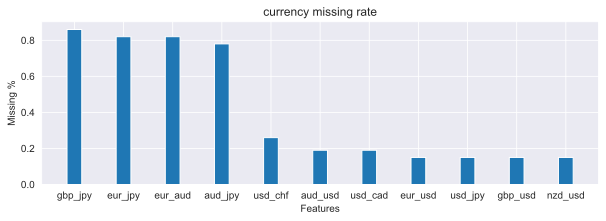

In [353]:
cal_perc_missing(currency, title='currency missing rate')

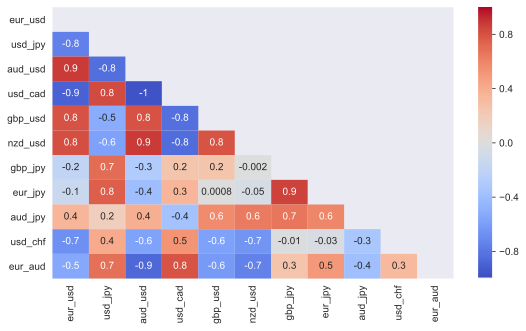

In [347]:
heatmap(currency, shape = (9,5), annot=True)

##### Alt Crypto- Currency Data Exploration

In [236]:
## Top 10 cryptocurrency
# Ethereum (ETH) $19.4bn
# XRP (XRP) $8.22bn
# Tether (USDT) $6.4bn
# Bitcoin Cash (BCH) $4.1bn
# Litecoin (LTC) $2.6bn
# EOS (EOS) $2.4bn
# Binance Coin (BNB) $2.4bn
# dogecoin

xrp = yf.Ticker('XRP-USD')
xrp = xrp.history(start = start_date)

usdt = yf.Ticker('USDT-USD')
usdt = usdt.history(start = start_date)

bch = yf.Ticker('BCH-USD')
bch = bch.history(start = start_date)

ltc = yf.Ticker('LTC-USD')
ltc = ltc.history(start = start_date)

eos = yf.Ticker('EOS-USD')
eos = eos.history(start = start_date)

bnb = yf.Ticker('BNB-USD')
bnb = bnb.history(start = start_date)

doge = yf.Ticker('DOGE-USD')
doge = doge.history(start = start_date)

eos = yf.Ticker('EOS-USD')
eos = eos.history(start = start_date)

zec = yf.Ticker('ZEC-USD')
zec = zec.history(start = start_date)

crypto_df = pd.concat([eth['Close'], xrp['Close'], usdt['Close'], bch['Close'], 
                    ltc['Close'], eos['Close'], bnb['Close'], doge['Close'], 
                    eos['Close'], zec['Close']], axis = 1)
crypto_df.columns = ['eth', 'xrp', 'usdt', 'bch', 'ltc', 'eoc', 'bnb', 'doge', 'eos', 'zec']

crypto_df

eth     xrp    usdt     bch    ltc     eoc    bnb    doge  \
Date                                                                       
2014-09-17     NaN  0.0054     NaN     NaN   5.06     NaN    NaN  0.0003   
2014-09-18     NaN  0.0051     NaN     NaN   4.69     NaN    NaN  0.0003   
2014-09-19     NaN  0.0049     NaN     NaN   4.33     NaN    NaN  0.0003   
2014-09-20     NaN  0.0048     NaN     NaN   4.29     NaN    NaN  0.0003   
2014-09-21     NaN  0.0046     NaN     NaN   4.25     NaN    NaN  0.0003   
...            ...     ...     ...     ...    ...     ...    ...     ...   
2020-09-13  365.57  0.2418  0.9992  221.83  48.07  2.7197  31.06  0.0028   
2020-09-14  377.27  0.2463  1.0013  226.26  49.09  2.7385  31.18  0.0028   
2020-09-15  364.84  0.2438  1.0025  235.63  48.39  2.7106  27.20  0.0028   
2020-09-16  366.54     NaN     NaN     NaN    NaN     NaN    NaN     NaN   
2020-09-17     NaN  0.2506  1.0020  233.60  48.57  2.7306  26.81  0.0028   

               eos    zec  
Date                       
2014-09-17     NaN    NaN  
2014-09-18     NaN    NaN  
2014-09-19     NaN    NaN  
2014-09-20     NaN    NaN  
2014-09-21     NaN    NaN  
...            ...    ...  
2020-09-13  2.7197  62.60  
2020-09-14  2.7385  63.32  
2020-09-15  2.7106  59.50  
2020-09-16     NaN    NaN  
2020-09-17  2.7306  58.48  

[2192 rows x 10 columns]

In [238]:
crypto_df.describe()

eth          xrp         usdt          bch          ltc  \
count  1867.000000  2191.000000  2025.000000  1151.000000  2191.000000   
mean    208.823460     0.225842     1.000803   543.906403    44.822958   
std     228.212731     0.318282     0.016662   523.537656    53.487492   
min       0.430000     0.004100     0.606200    77.370000     1.160000   
25%      12.060000     0.007700     1.000000   234.370000     3.780000   
50%     171.640000     0.193500     1.000000   330.230000    38.870000   
75%     284.165000     0.309950     1.002800   622.315000    60.645000   
max    1396.420000     3.377800     1.211100  3923.070000   358.340000   

               eoc          bnb         doge          eos          zec  
count  1173.000000  1149.000000  2191.000000  1173.000000  1418.000000  
mean      4.733463    14.272802     0.001795     4.733463   142.295212  
std       3.360201     8.202904     0.001900     3.360201   151.083665  
min       0.493200     0.100000     0.000100     0.493200    24.500000  
25%       2.603200     9.370000     0.000200     2.603200    50.805000  
50%       3.638700    14.170000     0.001800     3.638700    72.450000  
75%       5.879900    18.670000     0.002700     5.879900   206.270000  
max      21.542600    38.820000     0.017100    21.542600  2044.470000

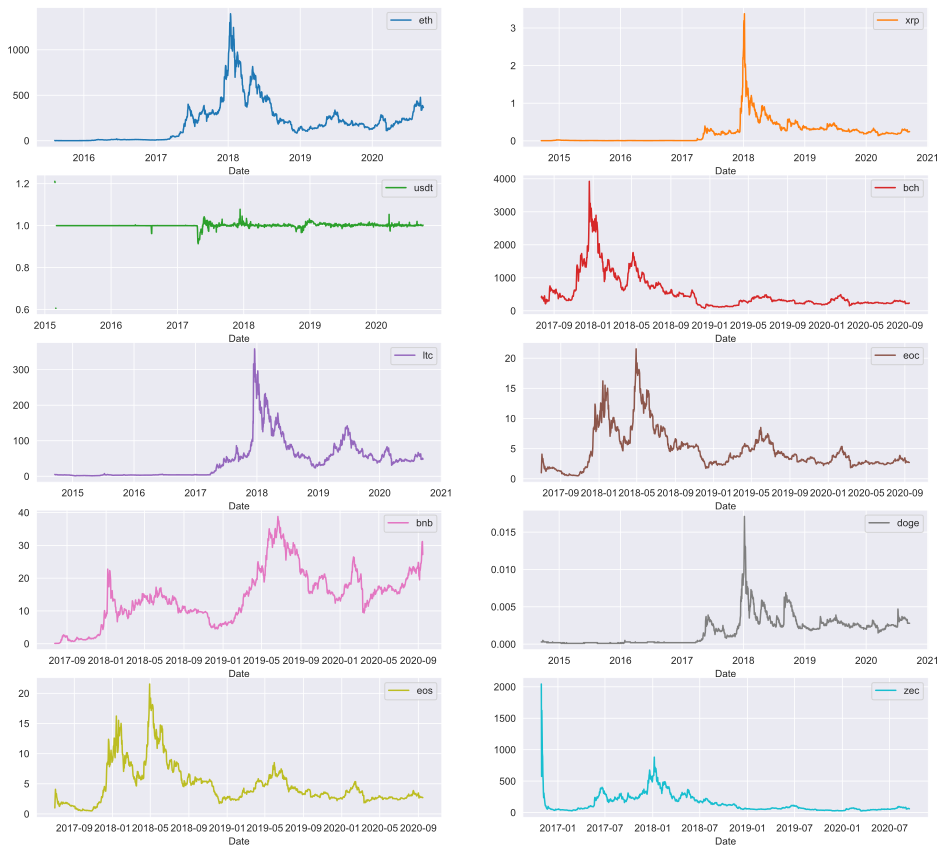

In [350]:
temp = crypto_df
x = math.ceil(currency.shape[1]/2)
temp.plot(figsize = (16,3*x), subplots = True, sharex = False, layout=(x,2));

bnb    bch    eoc    eos    zec    eth  usdt   xrp   ltc  doge
Missing %  47.58  47.49  46.49  46.49  35.31  14.83  7.62  0.05  0.05  0.05

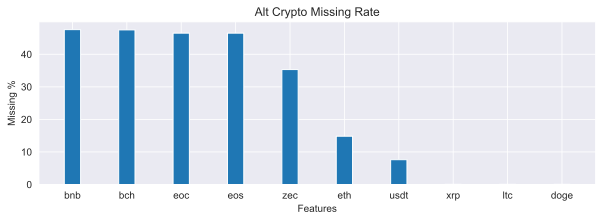

In [352]:
cal_perc_missing(crypto_df, title='Alt Crypto Missing Rate')

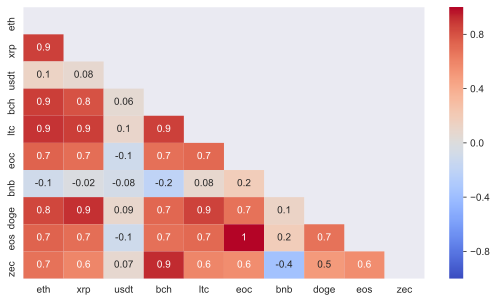

In [295]:
heatmap(crypto_df, shape = (9,5), annot=True)